In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from scipy import stats 
import time
from datetime import timedelta, datetime, date
import holidays


# prophet model
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

# Cost Functions
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

/home/bildad/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
def mape(actual, pred):
    """Calculate Mean Absolute Percentage Error"""
    actual, pred = np.array(actual), np.array(pred)
    
    return mean_absolute_percentage_error(actual, pred) * 100

In [4]:
train_df = pd.read_csv('./csvs/train.csv')

In [5]:
train_df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [6]:
train_df.drop(columns=['id'], inplace=True)

In [7]:
train_df.head()

date  store_nbr      family  sales  onpromotion
0  2013-01-01          1  AUTOMOTIVE    0.0            0
1  2013-01-01          1   BABY CARE    0.0            0
2  2013-01-01          1      BEAUTY    0.0            0
3  2013-01-01          1   BEVERAGES    0.0            0
4  2013-01-01          1       BOOKS    0.0            0

In [8]:
train_df['date'] = pd.to_datetime(train_df['date'], format="ISO8601")

In [9]:
train_df['family'].value_counts().count()

np.int64(33)

- What columns affect the final output(sales)?
- date, family

## We can make date the index, each index containing family and sales for each family

In [10]:
train_df.groupby(['date']).agg({'sales': 'sum'}) # Sum of sales for each date

sales
date                     
2013-01-01    2511.618999
2013-01-02  496092.417944
2013-01-03  361461.231124
2013-01-04  354459.677093
2013-01-05  477350.121229
...                   ...
2017-08-11  826373.722022
2017-08-12  792630.535079
2017-08-13  865639.677471
2017-08-14  760922.406081
2017-08-15  762661.935939

[1684 rows x 1 columns]

In [11]:
train_df.groupby(['family']).agg({'sales': 'sum'})

sales
family                                  
AUTOMOTIVE                  5.548220e+05
BABY CARE                   1.005100e+04
BEAUTY                      3.378930e+05
BEVERAGES                   2.169545e+08
BOOKS                       6.438000e+03
BREAD/BAKERY                4.213395e+07
CELEBRATION                 7.611770e+05
CLEANING                    9.752129e+07
DAIRY                       6.448771e+07
DELI                        2.411032e+07
EGGS                        1.558830e+07
FROZEN FOODS                1.407389e+07
GROCERY I                   3.434627e+08
GROCERY II                  1.962767e+06
HARDWARE                    1.034700e+05
HOME AND KITCHEN I          1.861491e+06
HOME AND KITCHEN II         1.520670e+06
HOME APPLIANCES             4.160100e+04
HOME CARE                   1.602274e+07
LADIESWEAR                  6.511590e+05
LAWN AND GARDEN             5.488420e+05
LINGERIE                    6.531140e+05
LIQUOR,WINE,BEER            7.746640e+06
MAGAZINES                   2.663590e+05
MEATS                       3.108647e+07
PERSONAL CARE               2.459205e+07
PET SUPPLIES                3.565840e+05
PLAYERS AND ELECTRONICS     5.626080e+05
POULTRY                     3.187600e+07
PREPARED FOODS              8.799895e+06
PRODUCE                     1.227047e+08
SCHOOL AND OFFICE SUPPLIES  2.693160e+05
SEAFOOD                     2.015432e+06

In [12]:
total_sales_df = train_df.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index().sort_values(['family', 'date'])

In [13]:
total_sales_df

date      family        sales
0     2013-01-01  AUTOMOTIVE     0.000000
33    2013-01-02  AUTOMOTIVE   255.000000
66    2013-01-03  AUTOMOTIVE   161.000000
99    2013-01-04  AUTOMOTIVE   169.000000
132   2013-01-05  AUTOMOTIVE   342.000000
...          ...         ...          ...
55439 2017-08-11     SEAFOOD  1272.615997
55472 2017-08-12     SEAFOOD  1028.030006
55505 2017-08-13     SEAFOOD  1118.047000
55538 2017-08-14     SEAFOOD   970.679999
55571 2017-08-15     SEAFOOD   970.177005

[55572 rows x 3 columns]

In [14]:
reshaped_df = total_sales_df.pivot(columns='family', index='date', values='sales')
reshaped_df

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01         0.0        0.0     2.0      810.0    0.0     180.58900   
2013-01-02       255.0        0.0   207.0    72092.0    0.0   26246.31900   
2013-01-03       161.0        0.0   125.0    52105.0    0.0   18456.48002   
2013-01-04       169.0        0.0   133.0    54167.0    0.0   16721.96901   
2013-01-05       342.0        0.0   191.0    77818.0    0.0   22367.76108   
...                ...        ...     ...        ...    ...           ...   
2017-08-11       441.0        7.0   351.0   189111.0    0.0   28204.48600   
2017-08-12       403.0        3.0   369.0   182318.0    0.0   27403.54800   
2017-08-13       481.0        9.0   433.0   202354.0    1.0   33262.75700   
2017-08-14       292.0        9.0   337.0   174832.0    0.0   28002.45700   
2017-08-15       337.0        8.0   339.0   170773.0    0.0   29158.19502   

family      CELEBRATION  CLEANING    DAIRY          DELI  ...  MAGAZINES  \
date                                                      ...              
2013-01-01          0.0     186.0    143.0     71.090000  ...        0.0   
2013-01-02          0.0   74629.0  23381.0  15754.500000  ...        0.0   
2013-01-03          0.0   55893.0  18001.0  11172.455000  ...        0.0   
2013-01-04          0.0   52064.0  18148.0  10143.209000  ...        0.0   
2013-01-05          0.0   70128.0  23082.0  13734.945010  ...        0.0   
...                 ...       ...      ...           ...  ...        ...   
2017-08-11        870.0   55682.0  44909.0  18680.488004  ...      500.0   
2017-08-12        849.0   57935.0  42854.0  15689.893010  ...      483.0   
2017-08-13        544.0   61757.0  50112.0  17593.274020  ...      469.0   
2017-08-14        594.0   55032.0  43050.0  14662.741000  ...      457.0   
2017-08-15        597.0   58474.0  40707.0  14935.453000  ...      461.0   

family             MEATS  PERSONAL CARE  PET SUPPLIES  \
date                                                    
2013-01-01    110.801000           25.0           0.0   
2013-01-02  20871.464028        17204.0           0.0   
2013-01-03  16597.398113        12568.0           0.0   
2013-01-04  21625.963055        11303.0           0.0   
2013-01-05  20879.091050        16819.0           0.0   
...                  ...            ...           ...   
2017-08-11  26944.092010        15978.0         587.0   
2017-08-12  17775.650112        15903.0         508.0   
2017-08-13  18633.015039        18188.0         541.0   
2017-08-14  16975.686040        15077.0         417.0   
2017-08-15  17928.170944        14787.0         364.0   

family      PLAYERS AND ELECTRONICS       POULTRY  PREPARED FOODS  \
date                                                                
2013-01-01                      0.0     42.637000       37.847000   
2013-01-02                      0.0  13975.884938     5338.111976   
2013-01-03                      0.0  10674.393983     3591.388005   
2013-01-04                      0.0  10772.515038     4472.965990   
2013-01-05                      0.0  13475.009055     5830.073020   
...                             ...           ...             ...   
2017-08-11                    654.0  25318.297990     5199.494021   
2017-08-12                    712.0  19134.510058     4573.465992   
2017-08-13                    741.0  20509.265004     4941.509018   
2017-08-14                    500.0  18597.508060     4647.375002   
2017-08-15                    592.0  17586.709986     4641.522980   

family           PRODUCE  SCHOOL AND OFFICE SUPPLIES      SEAFOOD  
date                                                               
2013-01-01       0.00000                         0.0     0.000000  
2013-01-02       0.00000                         0.0  1526.750002  
2013-01-03       0.00000                         0.0  1094.310994  
2013-01-04       0.00000     

## Analyze distribution of sales across different families

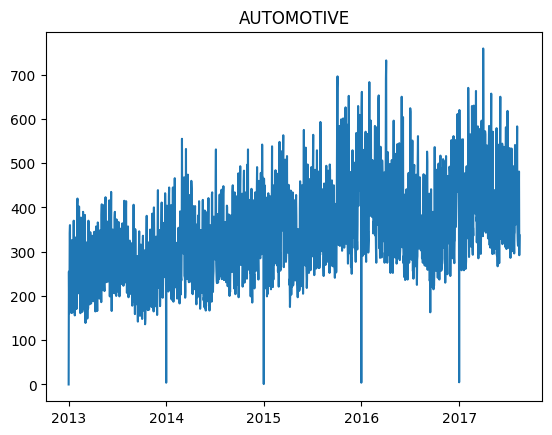

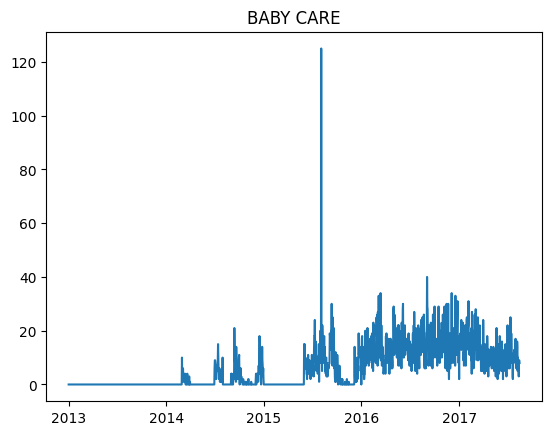

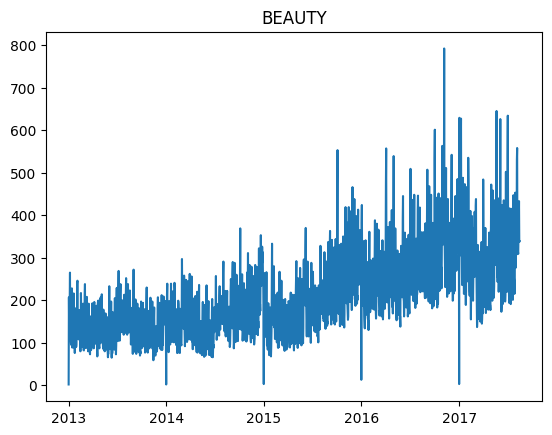

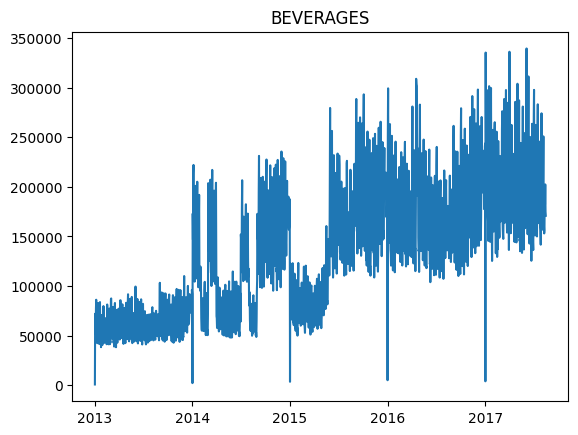

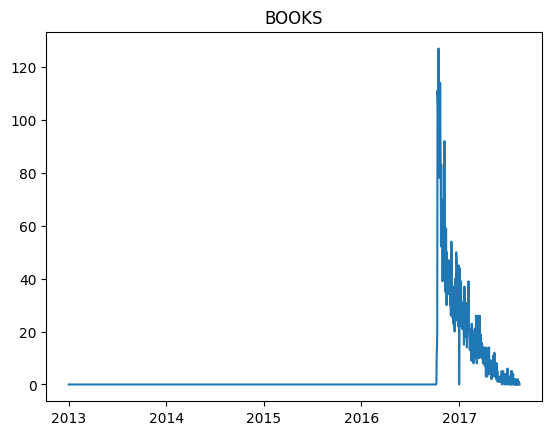

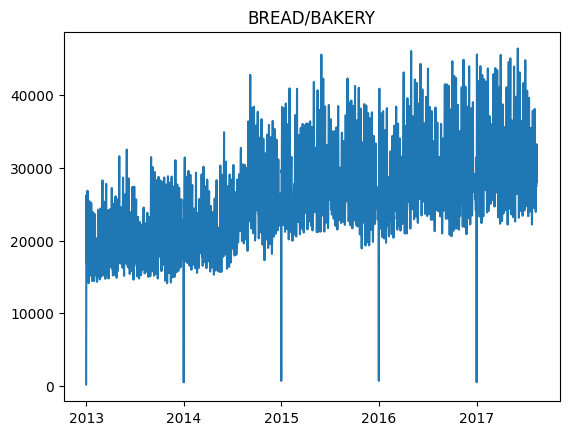

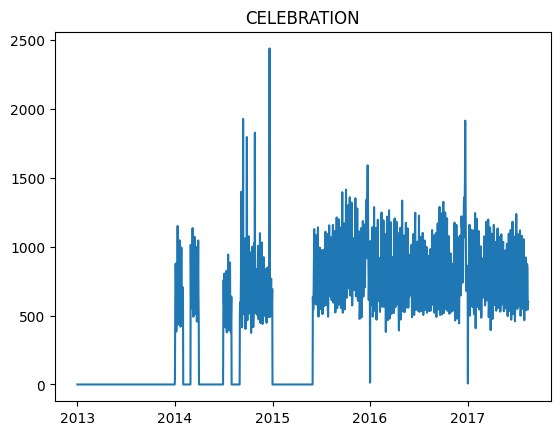

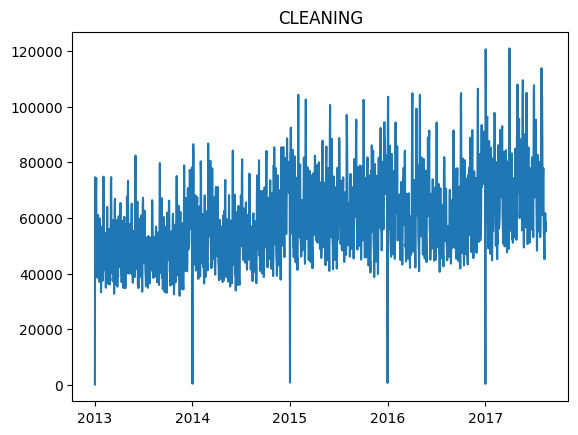

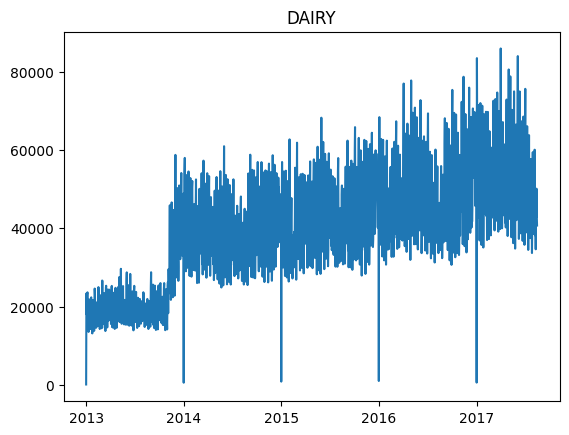

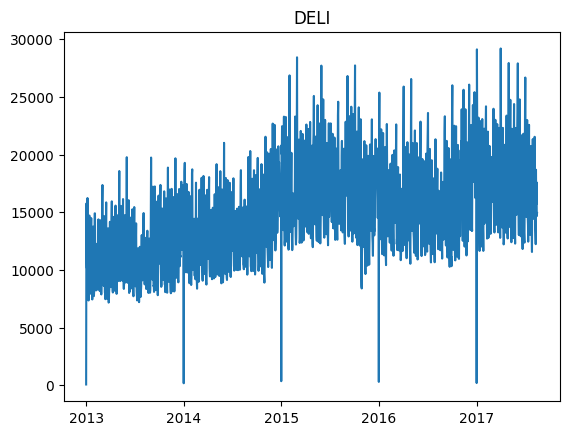

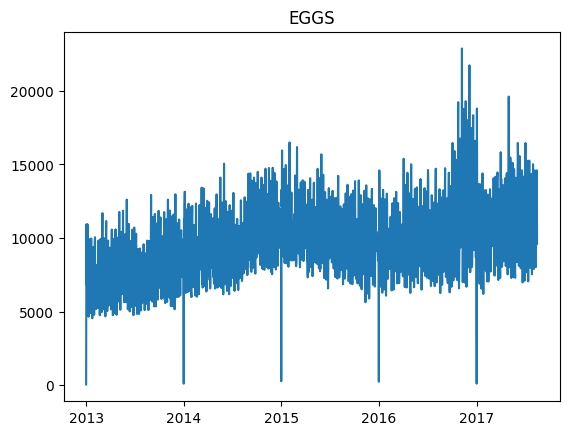

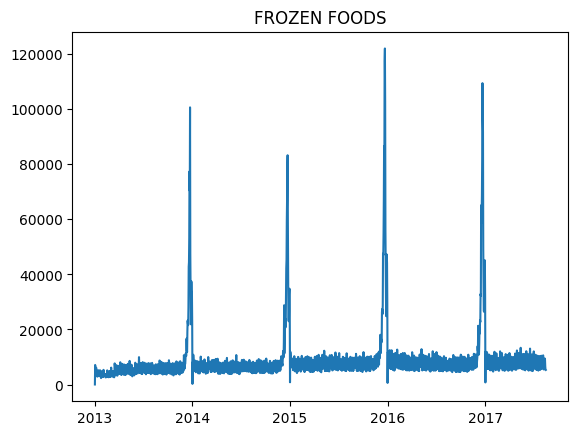

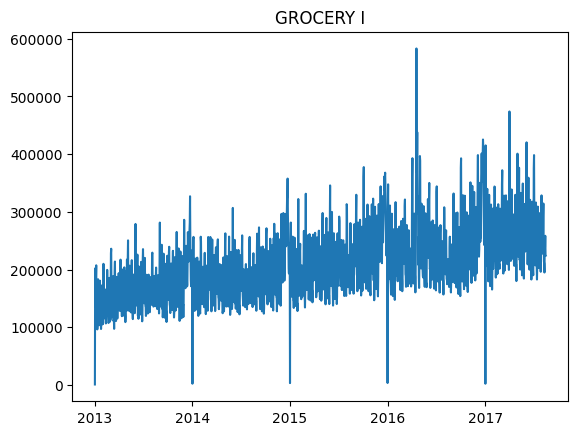

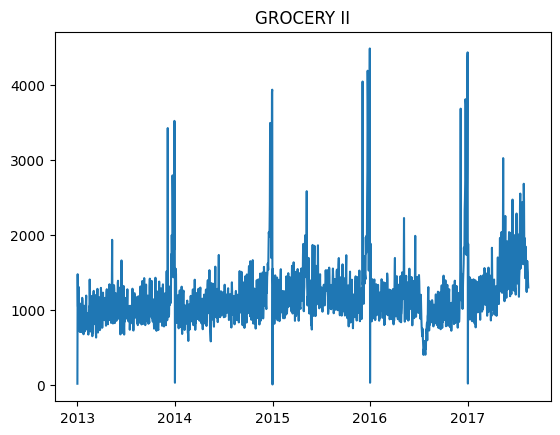

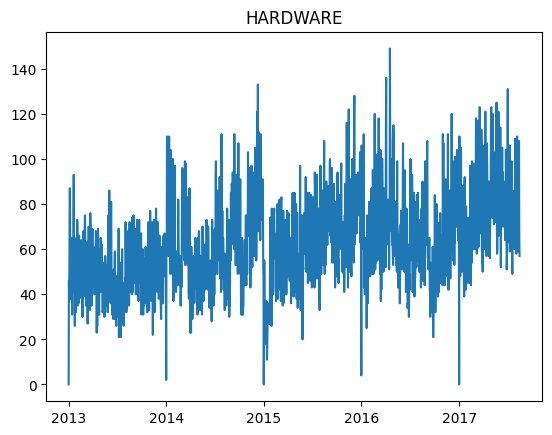

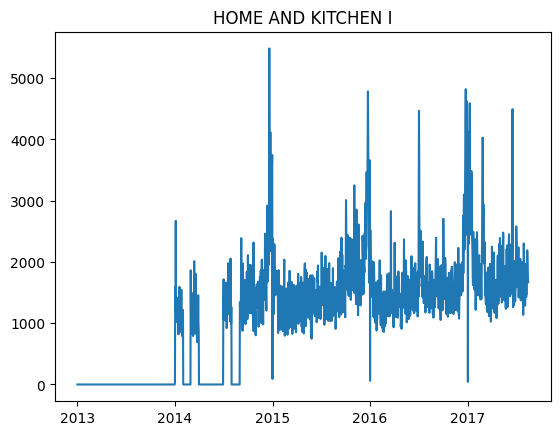

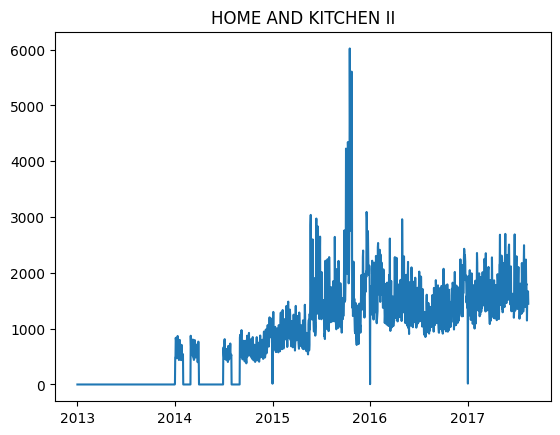

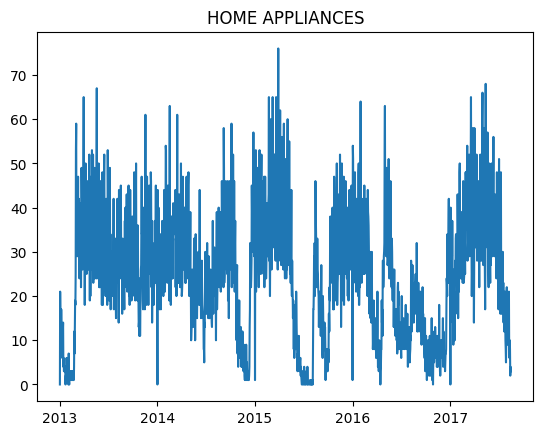

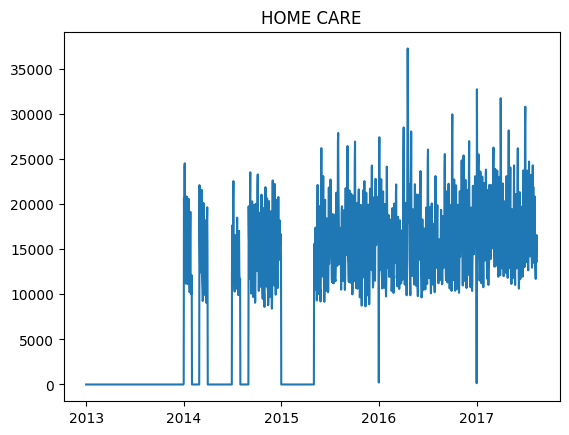

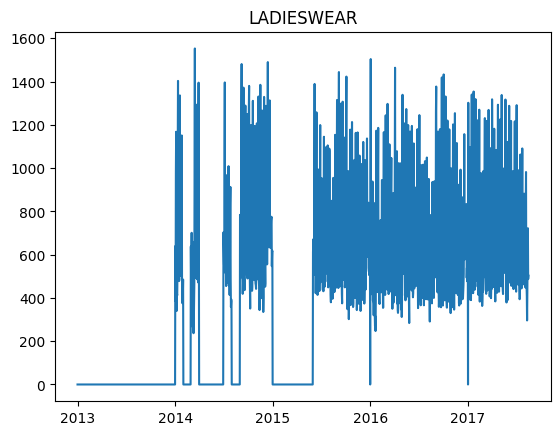

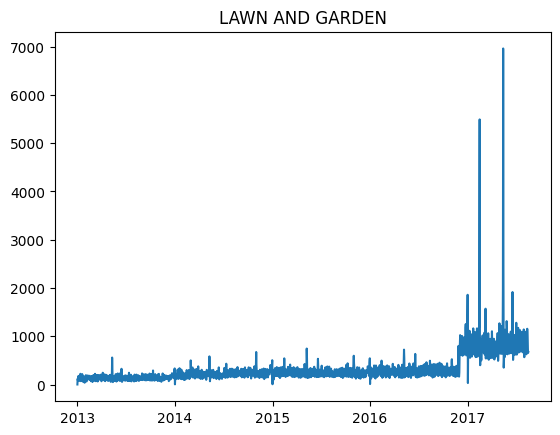

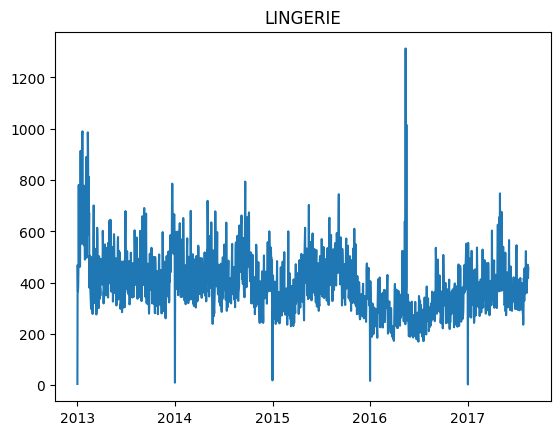

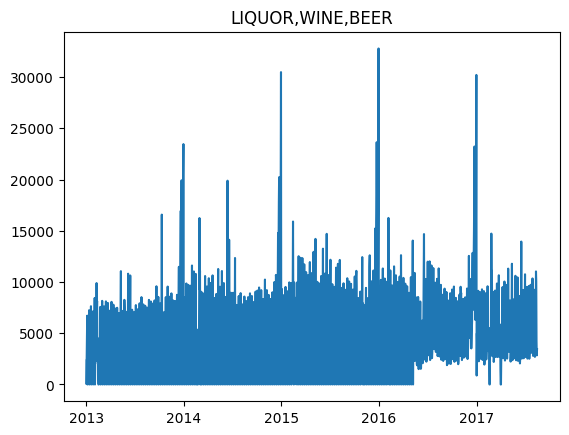

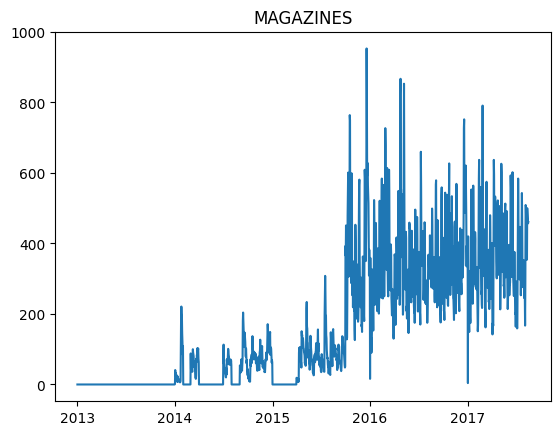

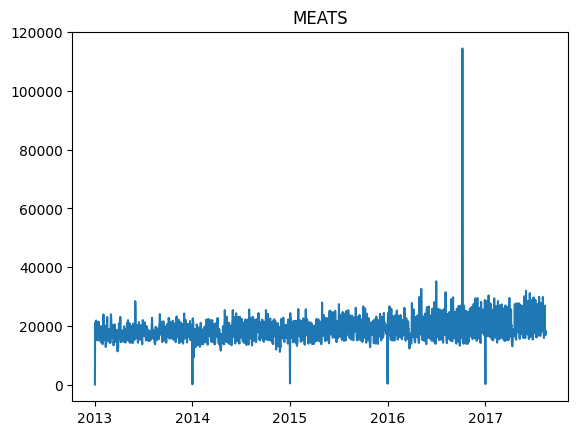

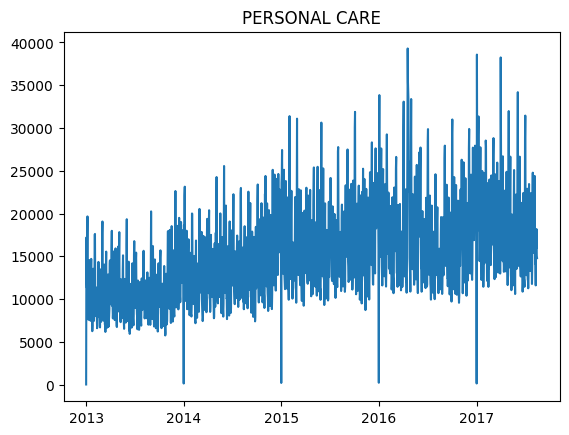

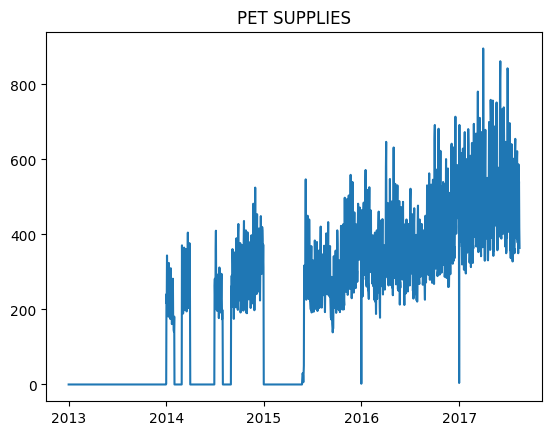

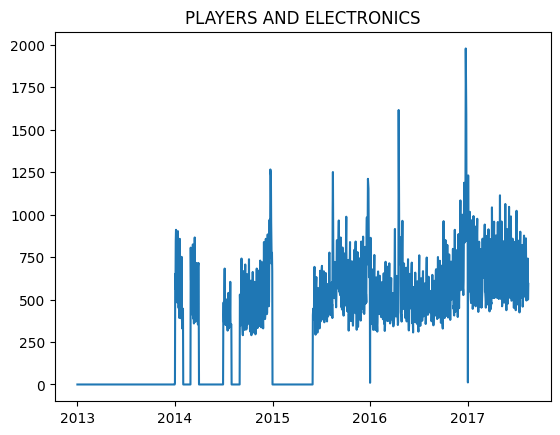

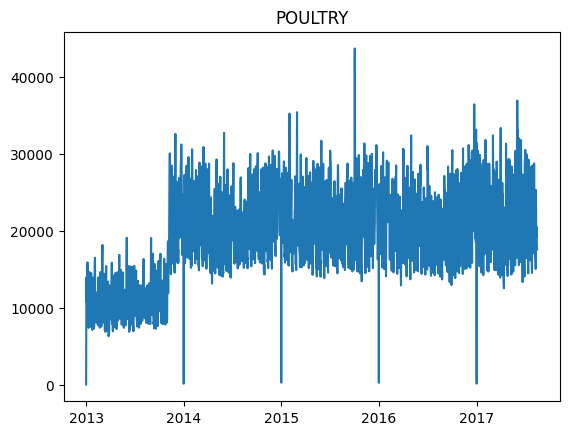

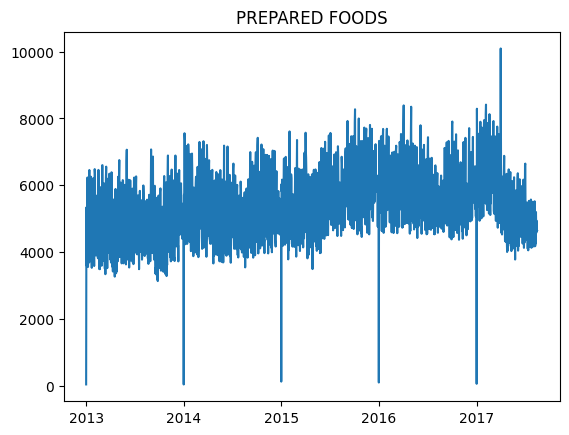

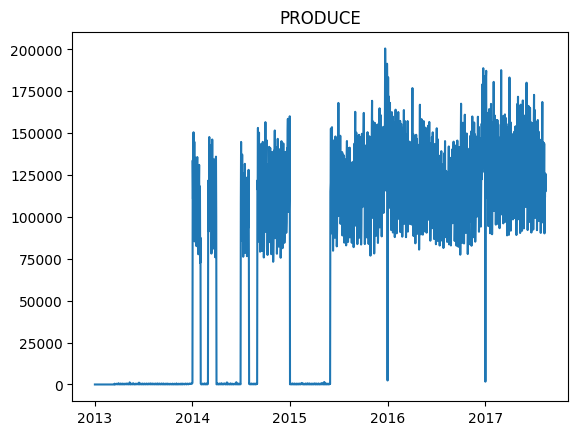

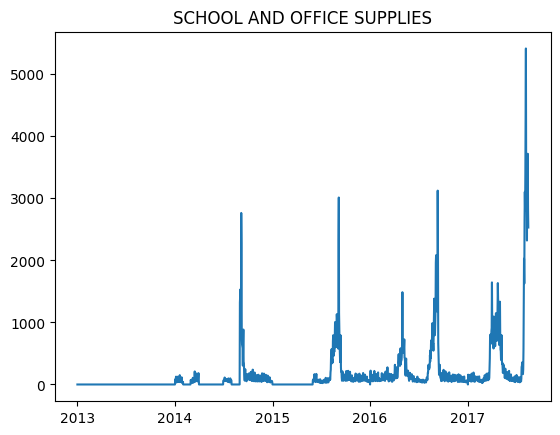

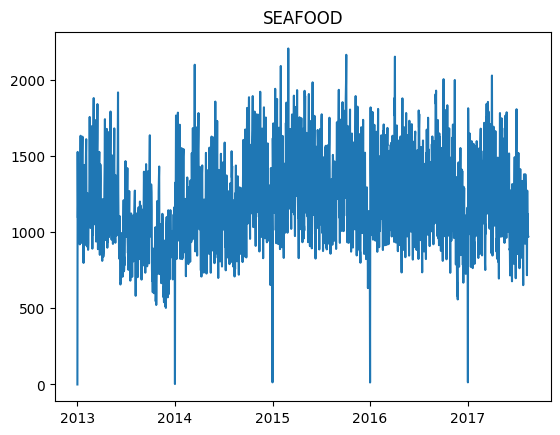

In [15]:
for column in reshaped_df.columns:
    plt.plot(reshaped_df[column])
    plt.title(column)
    plt.show()

In [16]:
reshaped_df = reshaped_df[reshaped_df.index > '2015-08-03']
reshaped_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2015-08-04       324.0      125.0   200.0   146430.0    0.0   26616.68300   
2015-08-05       350.0       10.0   168.0   145053.0    0.0   25987.71300   
2015-08-06       301.0       15.0   174.0   122278.0    0.0   22822.82200   
2015-08-07       370.0        5.0   175.0   141550.0    0.0   24584.54203   
2015-08-08       441.0       22.0   235.0   174314.0    0.0   28077.58320   

family      CELEBRATION  CLEANING    DAIRY       DELI  ...  MAGAZINES  \
date                                                   ...              
2015-08-04        667.0   64432.0  38948.0  16875.735  ...       31.0   
2015-08-05        671.0   59582.0  39079.0  15371.550  ...       27.0   
2015-08-06        638.0   50170.0  31195.0  13994.000  ...       93.0   
2015-08-07        870.0   54082.0  35813.0  16326.742  ...      148.0   
2015-08-08       1067.0   65274.0  43406.0  17777.225  ...      130.0   

family             MEATS  PERSONAL CARE  PET SUPPLIES  \
date                                                    
2015-08-04  17690.184106        16785.0         250.0   
2015-08-05  17532.612018        15094.0         238.0   
2015-08-06  17012.683052        12754.0         205.0   
2015-08-07  25385.481010        12610.0         212.0   
2015-08-08  18293.946886        17481.0         279.0   

family      PLAYERS AND ELECTRONICS       POULTRY  PREPARED FOODS  \
date                                                                
2015-08-04                    505.0  18661.279010     5100.428996   
2015-08-05                    538.0  18507.312974     5402.155986   
2015-08-06                    408.0  16452.002026     4850.973977   
2015-08-07                    471.0  24707.564006     5324.202020   
2015-08-08                    519.0  21473.944896     6084.061014   

family           PRODUCE  SCHOOL AND OFFICE SUPPLIES      SEAFOOD  
date                                                               
2015-08-04  118632.00900                        91.0   996.956000  
2015-08-05  141218.54502                        79.0  1030.124002  
2015-08-06   85066.31470                       198.0   858.379000  
2015-08-07   94648.00401                       239.0  1259.221002  
2015-08-08  110496.65800                       451.0  1152.328001  

[5 rows x 33 columns]

## Data Cleaning

1. Filter low-volume data
2. Outlier detection and treatment(zscore normalization)
3. Remove zero-values

### Filter low-volume data

In [17]:
reshaped_df.mean()

family
AUTOMOTIVE                       382.574899
BABY CARE                         11.985155
BEAUTY                           272.128205
BEVERAGES                     177189.554656
BOOKS                              8.688259
BREAD/BAKERY                   28481.512069
CELEBRATION                      770.834008
CLEANING                       64042.757085
DAIRY                          46893.649123
DELI                           16218.007009
EGGS                           10054.280702
FROZEN FOODS                    9777.458898
GROCERY I                     239381.219055
GROCERY II                      1245.392713
HARDWARE                          70.124157
HOME AND KITCHEN I              1700.000000
HOME AND KITCHEN II             1556.801619
HOME APPLIANCES                   23.129555
HOME CARE                      15720.807018
LADIESWEAR                       624.572200
LAWN AND GARDEN                  487.788124
LINGERIE                         345.207827
LIQUOR,WINE,BEER         

In [18]:
# reshaped_df.values.mean()
overral_mean = reshaped_df.mean().mean()
overral_mean

np.float64(24541.11318258365)

### Return a new DataFrame with column mean above 1000

In [19]:
original_len = len(reshaped_df.columns)
reshaped_df = reshaped_df[reshaped_df.columns[reshaped_df.apply(np.mean) > 1000]]

print(f"Dropping {original_len - len(reshaped_df.columns)} due to insufficient sales")

Dropping 14 due to insufficient sales


In [20]:
len(reshaped_df.columns)

19

### Filter by frequency of non-zero sales

In [21]:
# Find % of 0s in each column
# ((sum of 0 values) / (sum of all values)) * 100
((reshaped_df == 0).astype(int).sum() / reshaped_df.sum(axis=0)) * 100

family
BEVERAGES              0.000000
BREAD/BAKERY           0.000000
CLEANING               0.000000
DAIRY                  0.000000
DELI                   0.000000
EGGS                   0.000000
FROZEN FOODS           0.000000
GROCERY I              0.000000
GROCERY II             0.000000
HOME AND KITCHEN I     0.000000
HOME AND KITCHEN II    0.000000
HOME CARE              0.000000
LIQUOR,WINE,BEER       0.001126
MEATS                  0.000000
PERSONAL CARE          0.000000
POULTRY                0.000000
PREPARED FOODS         0.000000
PRODUCE                0.000000
SEAFOOD                0.000000
dtype: float64

In [22]:
reshaped_df.drop(columns=['LIQUOR,WINE,BEER'], inplace=True)

In [23]:
reshaped_df[['HOME CARE']].reset_index()

family       date  HOME CARE
0      2015-08-04    18894.0
1      2015-08-05    16201.0
2      2015-08-06    13422.0
3      2015-08-07    13333.0
4      2015-08-08    17381.0
..            ...        ...
736    2017-08-11    13747.0
737    2017-08-12    14692.0
738    2017-08-13    16564.0
739    2017-08-14    13818.0
740    2017-08-15    13644.0

[741 rows x 2 columns]

## Standardize to remove outliers

In [24]:
# zscore = (current_value - mean) /std

In [25]:
# Break each column into its own Dataframe
prediction_list = []
for column in reshaped_df.columns:
    df_clean = reshaped_df[[column]].reset_index() # provide new indices since np.where returns indexes of affected rows
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 3)[0] # 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print(f"Dropping {len(outlier_index)} rows of {column}")
    df_clean.drop(index=outlier_index, inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_list.append(df_clean)
    
    

prediction_list


Dropping 5 rows of BEVERAGES
Dropping 4 rows of BREAD/BAKERY
Dropping 5 rows of CLEANING
Dropping 6 rows of DAIRY
Dropping 7 rows of DELI
Dropping 11 rows of EGGS
Dropping 18 rows of FROZEN FOODS
Dropping 8 rows of GROCERY I
Dropping 13 rows of GROCERY II
Dropping 16 rows of HOME AND KITCHEN I
Dropping 10 rows of HOME AND KITCHEN II
Dropping 8 rows of HOME CARE
Dropping 3 rows of MEATS
Dropping 10 rows of PERSONAL CARE
Dropping 5 rows of POULTRY
Dropping 3 rows of PREPARED FOODS
Dropping 3 rows of PRODUCE
Dropping 4 rows of SEAFOOD


[family      BEVERAGES
 date                 
 2015-08-04   146430.0
 2015-08-05   145053.0
 2015-08-06   122278.0
 2015-08-07   141550.0
 2015-08-08   174314.0
 ...               ...
 2017-08-11   189111.0
 2017-08-12   182318.0
 2017-08-13   202354.0
 2017-08-14   174832.0
 2017-08-15   170773.0
 
 [736 rows x 1 columns],
 family      BREAD/BAKERY
 date                    
 2015-08-04   26616.68300
 2015-08-05   25987.71300
 2015-08-06   22822.82200
 2015-08-07   24584.54203
 2015-08-08   28077.58320
 ...                  ...
 2017-08-11   28204.48600
 2017-08-12   27403.54800
 2017-08-13   33262.75700
 2017-08-14   28002.45700
 2017-08-15   29158.19502
 
 [737 rows x 1 columns],
 family      CLEANING
 date                
 2015-08-04   64432.0
 2015-08-05   59582.0
 2015-08-06   50170.0
 2015-08-07   54082.0
 2015-08-08   65274.0
 ...              ...
 2017-08-11   55682.0
 2017-08-12   57935.0
 2017-08-13   61757.0
 2017-08-14   55032.0
 2017-08-15   58474.0
 
 [736 rows x 1 column

- Each family is its own dataframe now
- prediction list is an array containing the different dataframes

In [26]:
prediction_list

[family      BEVERAGES
 date                 
 2015-08-04   146430.0
 2015-08-05   145053.0
 2015-08-06   122278.0
 2015-08-07   141550.0
 2015-08-08   174314.0
 ...               ...
 2017-08-11   189111.0
 2017-08-12   182318.0
 2017-08-13   202354.0
 2017-08-14   174832.0
 2017-08-15   170773.0
 
 [736 rows x 1 columns],
 family      BREAD/BAKERY
 date                    
 2015-08-04   26616.68300
 2015-08-05   25987.71300
 2015-08-06   22822.82200
 2015-08-07   24584.54203
 2015-08-08   28077.58320
 ...                  ...
 2017-08-11   28204.48600
 2017-08-12   27403.54800
 2017-08-13   33262.75700
 2017-08-14   28002.45700
 2017-08-15   29158.19502
 
 [737 rows x 1 columns],
 family      CLEANING
 date                
 2015-08-04   64432.0
 2015-08-05   59582.0
 2015-08-06   50170.0
 2015-08-07   54082.0
 2015-08-08   65274.0
 ...              ...
 2017-08-11   55682.0
 2017-08-12   57935.0
 2017-08-13   61757.0
 2017-08-14   55032.0
 2017-08-15   58474.0
 
 [736 rows x 1 column

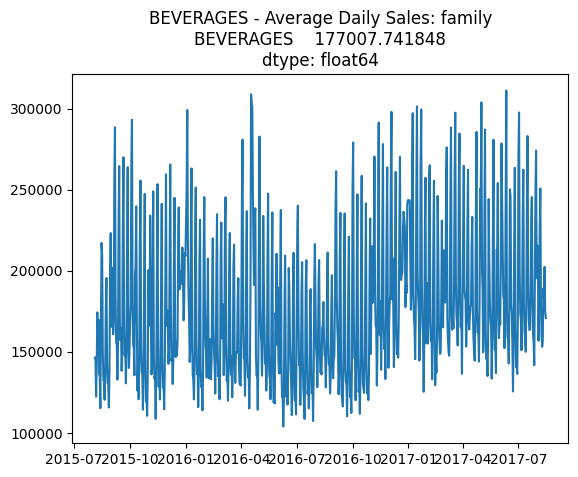

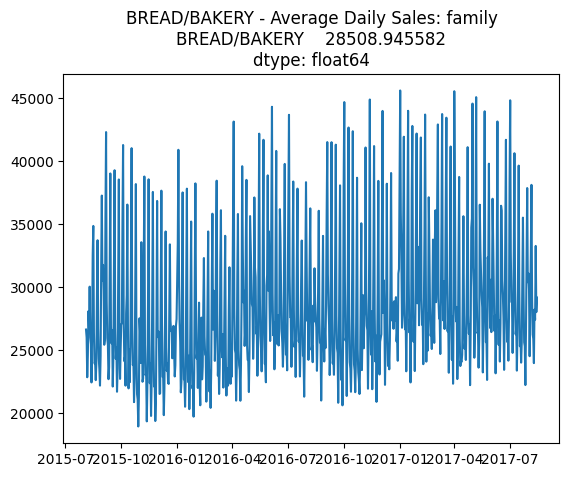

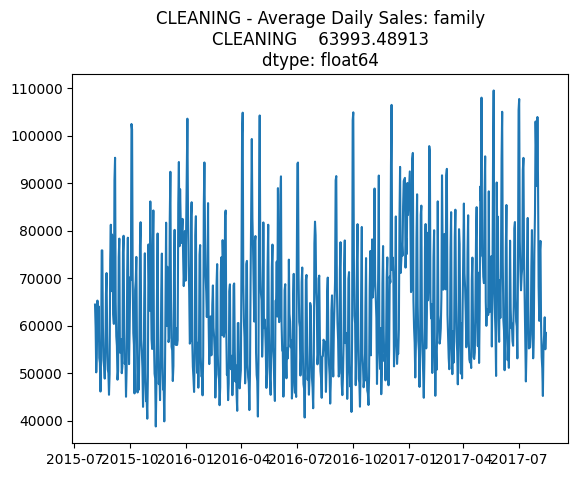

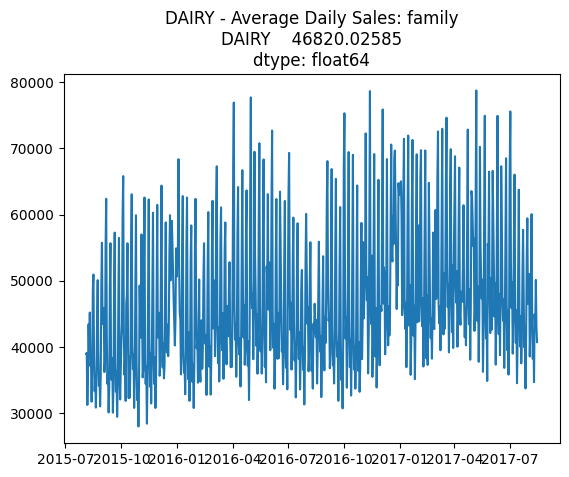

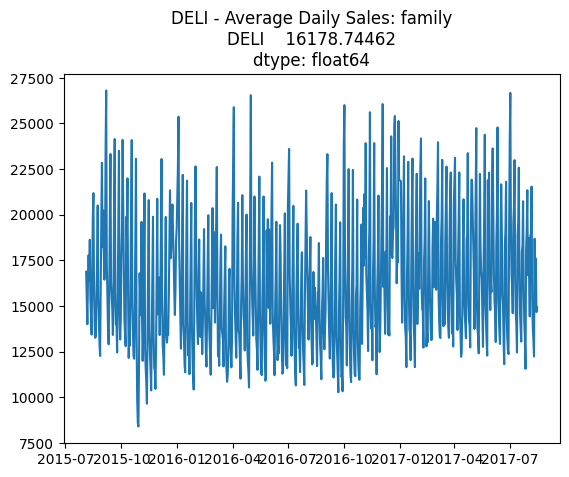

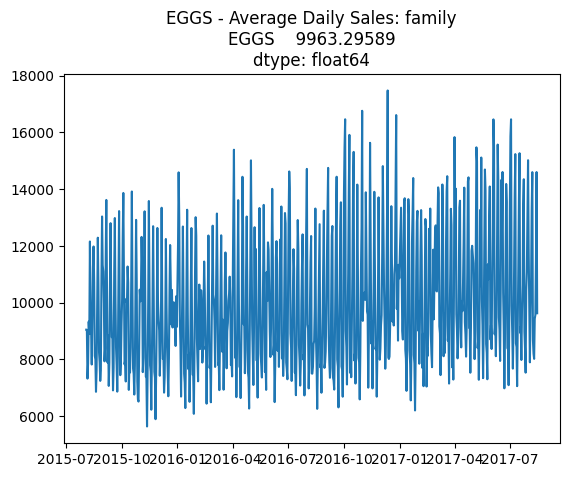

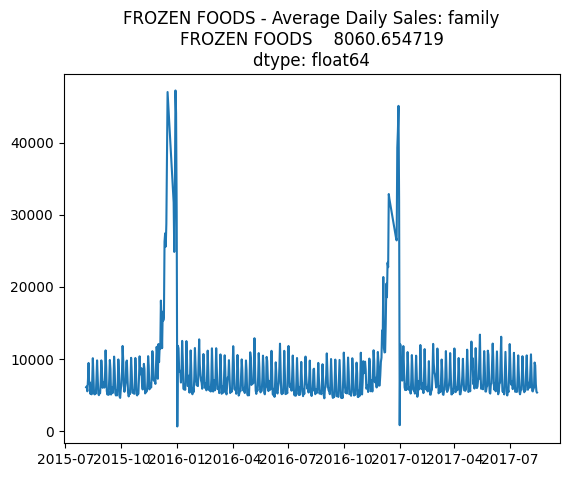

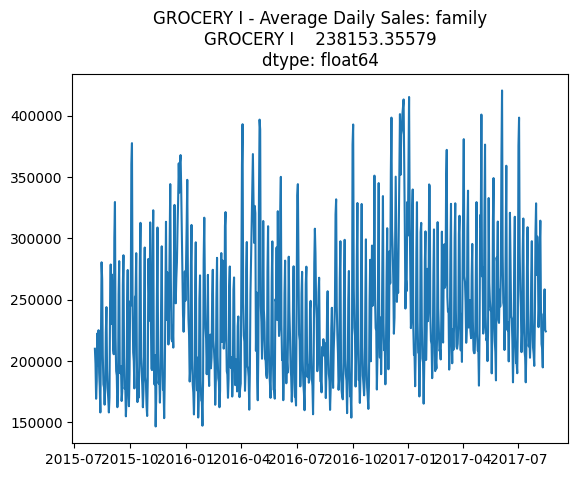

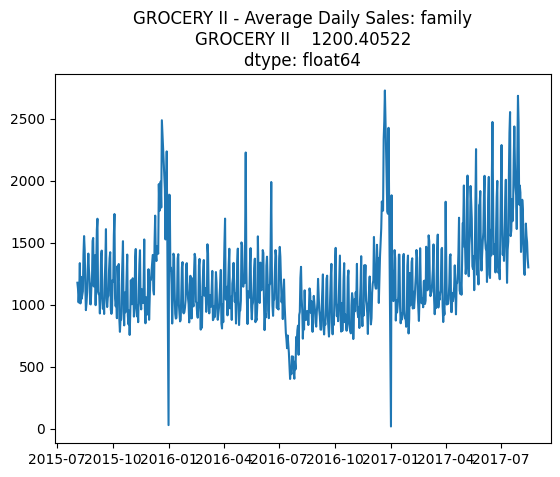

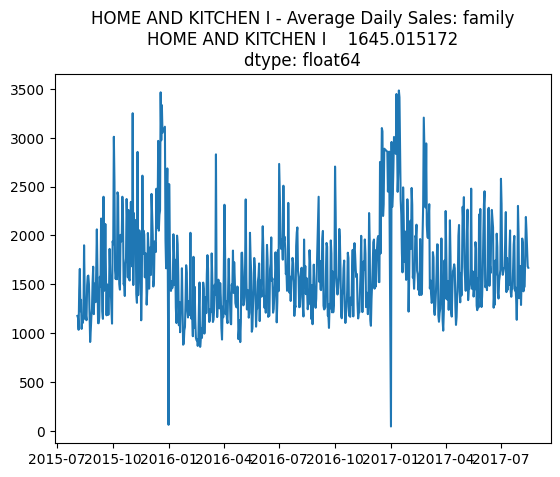

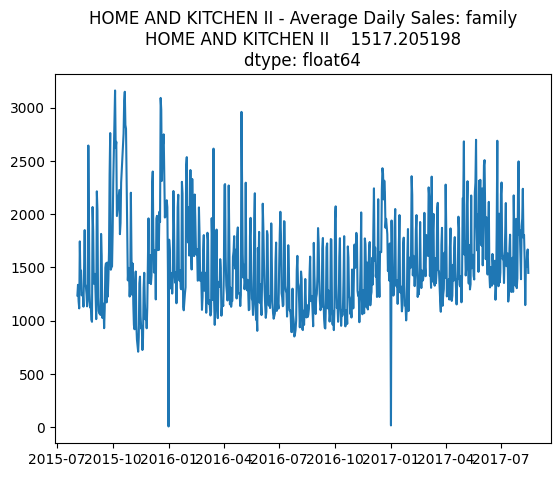

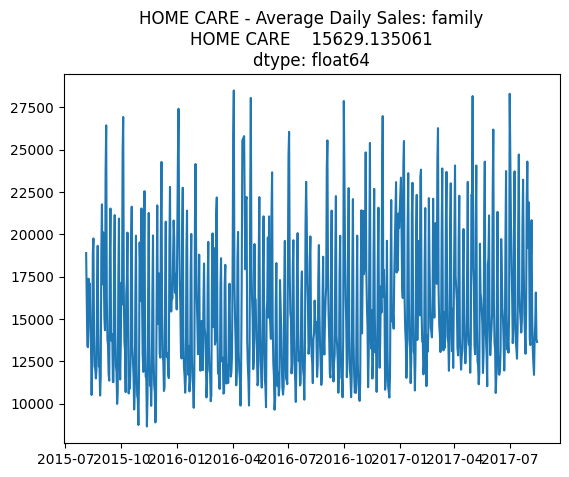

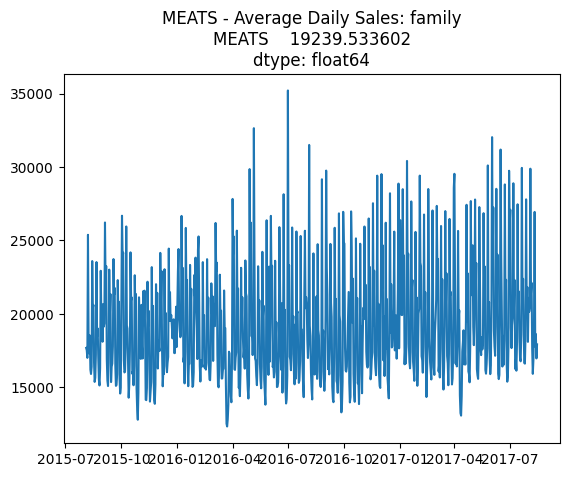

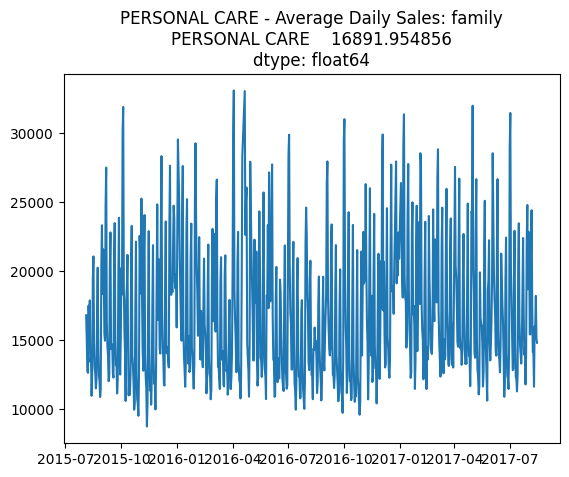

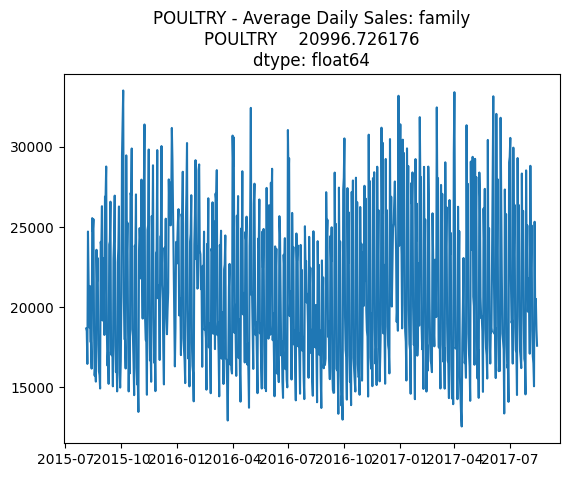

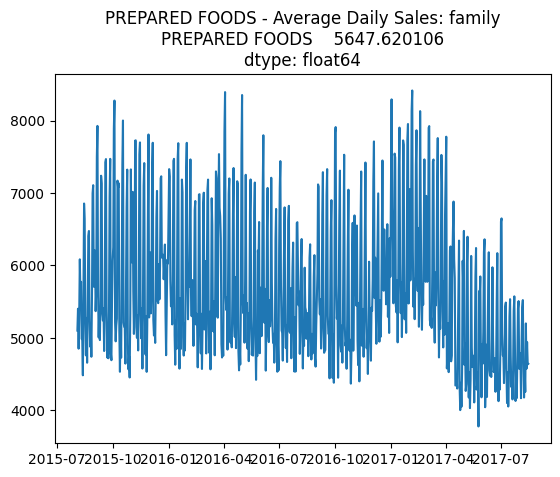

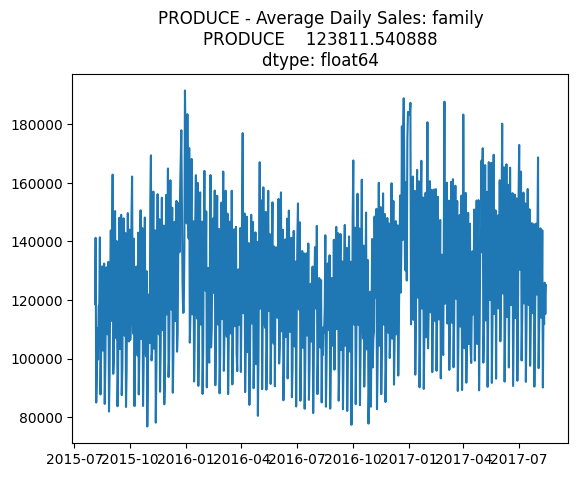

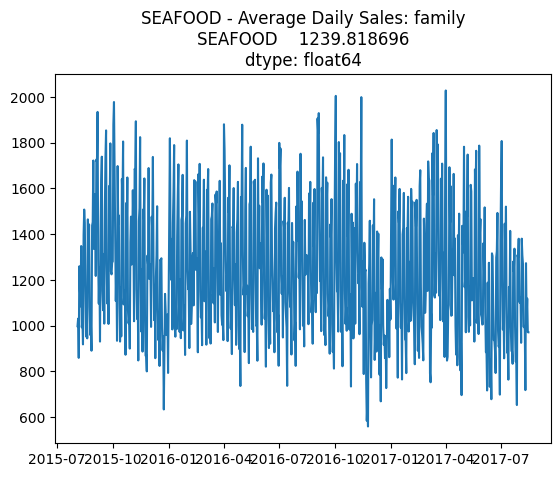

In [27]:
for i in range(len(prediction_list)):
    plt.plot(prediction_list[i])
    plt.title(prediction_list[i].columns[0] + " - Average Daily Sales: " + str(prediction_list[i].mean()))
    plt.show()
    

- Drop situations in **GROCERY II and FROZEN FOODS** category since there are 0s in January that weren't dropped

In [28]:
for i in range(len(prediction_list)):
    print(prediction_list[i].columns)

Index(['BEVERAGES'], dtype='object', name='family')
Index(['BREAD/BAKERY'], dtype='object', name='family')
Index(['CLEANING'], dtype='object', name='family')
Index(['DAIRY'], dtype='object', name='family')
Index(['DELI'], dtype='object', name='family')
Index(['EGGS'], dtype='object', name='family')
Index(['FROZEN FOODS'], dtype='object', name='family')
Index(['GROCERY I'], dtype='object', name='family')
Index(['GROCERY II'], dtype='object', name='family')
Index(['HOME AND KITCHEN I'], dtype='object', name='family')
Index(['HOME AND KITCHEN II'], dtype='object', name='family')
Index(['HOME CARE'], dtype='object', name='family')
Index(['MEATS'], dtype='object', name='family')
Index(['PERSONAL CARE'], dtype='object', name='family')
Index(['POULTRY'], dtype='object', name='family')
Index(['PREPARED FOODS'], dtype='object', name='family')
Index(['PRODUCE'], dtype='object', name='family')
Index(['SEAFOOD'], dtype='object', name='family')


## Categorize into low, mid and high volume

In [29]:
avg_daily_sales = reshaped_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(avg_daily_sales, [33, 66])
low, mid

(np.float64(9946.320198213332), np.float64(22656.641307797327))

In [30]:
low_vol_cols = avg_daily_sales[avg_daily_sales <= low].index
mid_vol_cols = avg_daily_sales[(avg_daily_sales > low) & (avg_daily_sales < mid)].index
high_vol_cols = avg_daily_sales[avg_daily_sales >= mid].index

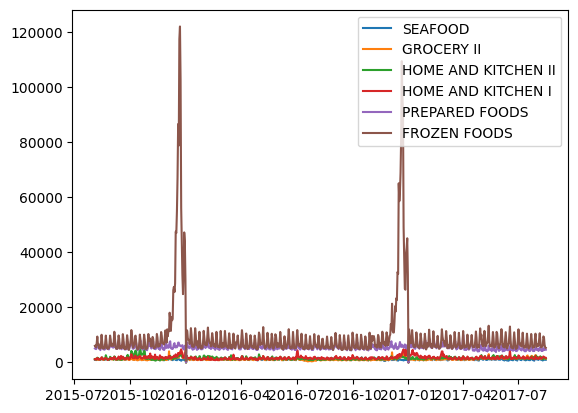

In [31]:
# Plot low volume columns
plt.plot(reshaped_df[low_vol_cols])
plt.legend(low_vol_cols)
plt.show()

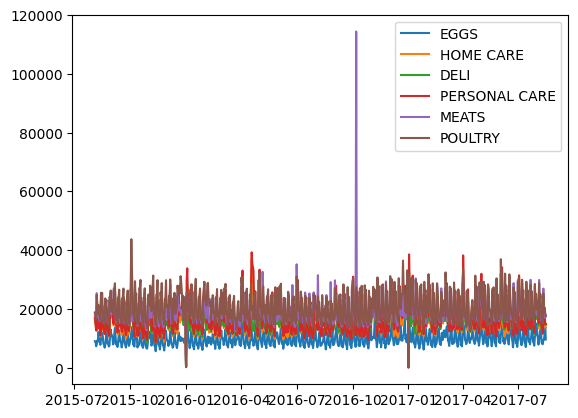

In [32]:
# Mid volume columns
plt.plot(reshaped_df[mid_vol_cols])
plt.legend(mid_vol_cols)
plt.show()

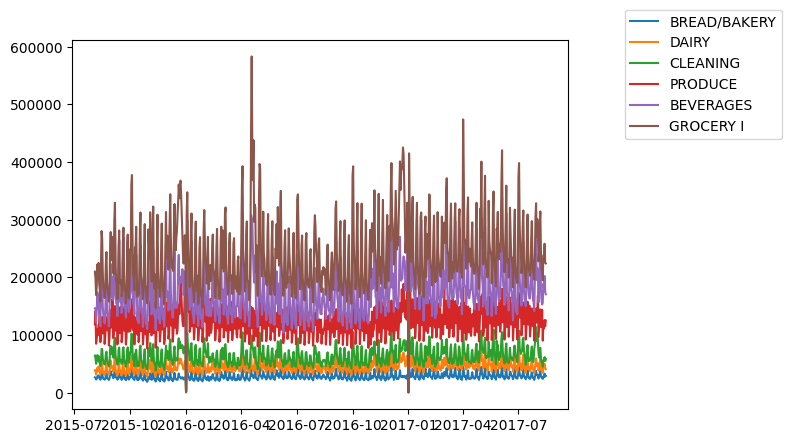

In [33]:
# high vol columns
plt.plot(reshaped_df[high_vol_cols])
plt.legend(high_vol_cols, loc='best',  bbox_to_anchor=(1.1, 1.1))
plt.show()

## Hyperparameter Tuning

### Ranges of hyperparameters
1. changepoint_prior_scale - [0.001, 0.5]
2. seasonality_prior_scale - [0.01, 10]
3. holiday_prior_scale - [0.01, 10]
4. seasonality_mode - ['additive', 'multiplicative']

In [34]:
changepoint_prior_scale = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale = np.linspace(0.01, 10, num=5).tolist()
holiday_prior_scale = np.linspace(0.01, 10, num=5).tolist()


In [35]:
dicts = {}
start_time = time.time()

for feature in reshaped_df.columns:
    category_df = reshaped_df[feature].copy().reset_index()
    category_df.columns = ['ds', 'y']
     
    category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
    category_df['ds'] = pd.to_datetime(category_df['ds'], format='%Y-%m-%d')
    
    param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale,
    'seasonality_prior_scale': seasonality_prior_scale,
    }
    
     #Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the MAPEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial='365 days', period='30 days', horizon='30 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['mape'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    print(feature)
    print(tuning_results)
    
    param_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    param_dict['column'] = feature
    dicts[feature] = param_dict
print("--- %s seconds ---" % (time.time() - start_time))

17:54:11 - cmdstanpy - INFO - Chain [1] start processing
17:54:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
17:54:13 - cmdstanpy - INFO - Chain [1] done processing
17:54:13 - cmdstanpy - INFO - Chain [1] done processing
17:54:13 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:13 - cmdstanpy - INFO - Chain [1] done processing
17:54:13 - cmdstan

BEVERAGES
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.290606
1                   0.00100                   2.5075  0.309772
2                   0.00100                   5.0050  0.309695
3                   0.00100                   7.5025  0.310702
4                   0.00100                  10.0000  0.310825
5                   0.12575                   0.0100  0.294300
6                   0.12575                   2.5075  0.300238
7                   0.12575                   5.0050  0.300870
8                   0.12575                   7.5025  0.301389
9                   0.12575                  10.0000  0.301551
10                  0.25050                   0.0100  0.297297
11                  0.25050                   2.5075  0.305975
12                  0.25050                   5.0050  0.305975
13                  0.25050                   7.5025  0.305689
14                  0.25050                  

17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 -

BREAD/BAKERY
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.291690
1                   0.00100                   2.5075  0.300529
2                   0.00100                   5.0050  0.299193
3                   0.00100                   7.5025  0.298847
4                   0.00100                  10.0000  0.299004
5                   0.12575                   0.0100  0.292040
6                   0.12575                   2.5075  0.296149
7                   0.12575                   5.0050  0.295932
8                   0.12575                   7.5025  0.296560
9                   0.12575                  10.0000  0.296433
10                  0.25050                   0.0100  0.287564
11                  0.25050                   2.5075  0.296451
12                  0.25050                   5.0050  0.296304
13                  0.25050                   7.5025  0.296076
14                  0.25050               

17:55:45 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 -

CLEANING
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.675072
1                   0.00100                   2.5075  0.726024
2                   0.00100                   5.0050  0.723741
3                   0.00100                   7.5025  0.724707
4                   0.00100                  10.0000  0.726497
5                   0.12575                   0.0100  0.684538
6                   0.12575                   2.5075  0.717899
7                   0.12575                   5.0050  0.717689
8                   0.12575                   7.5025  0.715885
9                   0.12575                  10.0000  0.716175
10                  0.25050                   0.0100  0.692331
11                  0.25050                   2.5075  0.725167
12                  0.25050                   5.0050  0.724973
13                  0.25050                   7.5025  0.725716
14                  0.25050                  1

17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 -

DAIRY
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.385646
1                   0.00100                   2.5075  0.386679
2                   0.00100                   5.0050  0.386399
3                   0.00100                   7.5025  0.387304
4                   0.00100                  10.0000  0.386679
5                   0.12575                   0.0100  0.380669
6                   0.12575                   2.5075  0.382426
7                   0.12575                   5.0050  0.382062
8                   0.12575                   7.5025  0.381971
9                   0.12575                  10.0000  0.382206
10                  0.25050                   0.0100  0.381571
11                  0.25050                   2.5075  0.382894
12                  0.25050                   5.0050  0.383284
13                  0.25050                   7.5025  0.382838
14                  0.25050                  10.0

17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:18 - 

DELI
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.414968
1                   0.00100                   2.5075  0.443268
2                   0.00100                   5.0050  0.443131
3                   0.00100                   7.5025  0.442070
4                   0.00100                  10.0000  0.443615
5                   0.12575                   0.0100  0.436373
6                   0.12575                   2.5075  0.452813
7                   0.12575                   5.0050  0.453629
8                   0.12575                   7.5025  0.453201
9                   0.12575                  10.0000  0.453369
10                  0.25050                   0.0100  0.438124
11                  0.25050                   2.5075  0.454903
12                  0.25050                   5.0050  0.453559
13                  0.25050                   7.5025  0.454029
14                  0.25050                  10.00

17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - 

EGGS
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.474615
1                   0.00100                   2.5075  0.477362
2                   0.00100                   5.0050  0.472478
3                   0.00100                   7.5025  0.472472
4                   0.00100                  10.0000  0.478953
5                   0.12575                   0.0100  0.489943
6                   0.12575                   2.5075  0.490934
7                   0.12575                   5.0050  0.491671
8                   0.12575                   7.5025  0.491563
9                   0.12575                  10.0000  0.491329
10                  0.25050                   0.0100  0.490783
11                  0.25050                   2.5075  0.487718
12                  0.25050                   5.0050  0.483401
13                  0.25050                   7.5025  0.483552
14                  0.25050                  10.00

17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1]

FROZEN FOODS
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.489487
1                   0.00100                   2.5075  0.541145
2                   0.00100                   5.0050  0.538570
3                   0.00100                   7.5025  0.539677
4                   0.00100                  10.0000  0.539287
5                   0.12575                   0.0100  0.523967
6                   0.12575                   2.5075  0.488861
7                   0.12575                   5.0050  0.488831
8                   0.12575                   7.5025  0.489054
9                   0.12575                  10.0000  0.489133
10                  0.25050                   0.0100  0.582213
11                  0.25050                   2.5075  0.485758
12                  0.25050                   5.0050  0.486152
13                  0.25050                   7.5025  0.485708
14                  0.25050               

17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 

GROCERY I
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.550970
1                   0.00100                   2.5075  0.568908
2                   0.00100                   5.0050  0.569045
3                   0.00100                   7.5025  0.569256
4                   0.00100                  10.0000  0.568805
5                   0.12575                   0.0100  0.564069
6                   0.12575                   2.5075  0.573455
7                   0.12575                   5.0050  0.573889
8                   0.12575                   7.5025  0.573505
9                   0.12575                  10.0000  0.573373
10                  0.25050                   0.0100  0.574773
11                  0.25050                   2.5075  0.581714
12                  0.25050                   5.0050  0.580737
13                  0.25050                   7.5025  0.581717
14                  0.25050                  

18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization te

GROCERY II
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.467413
1                   0.00100                   2.5075  0.517831
2                   0.00100                   5.0050  0.517409
3                   0.00100                   7.5025  0.516300
4                   0.00100                  10.0000  0.516954
5                   0.12575                   0.0100  0.448783
6                   0.12575                   2.5075  0.460317
7                   0.12575                   5.0050  0.459763
8                   0.12575                   7.5025  0.459604
9                   0.12575                  10.0000  0.459541
10                  0.25050                   0.0100  0.465144
11                  0.25050                   2.5075  0.462869
12                  0.25050                   5.0050  0.462660
13                  0.25050                   7.5025  0.462168
14                  0.25050                 

18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1

HOME AND KITCHEN I
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.388544
1                   0.00100                   2.5075  0.397107
2                   0.00100                   5.0050  0.400692
3                   0.00100                   7.5025  0.401365
4                   0.00100                  10.0000  0.400984
5                   0.12575                   0.0100  0.393064
6                   0.12575                   2.5075  0.401638
7                   0.12575                   5.0050  0.400897
8                   0.12575                   7.5025  0.399594
9                   0.12575                  10.0000  0.401268
10                  0.25050                   0.0100  0.400035
11                  0.25050                   2.5075  0.407232
12                  0.25050                   5.0050  0.411502
13                  0.25050                   7.5025  0.410662
14                  0.25050         

18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - ERROR - Chain [

HOME AND KITCHEN II
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.544416
1                   0.00100                   2.5075  0.605550
2                   0.00100                   5.0050  0.597639
3                   0.00100                   7.5025  0.612154
4                   0.00100                  10.0000  0.604070
5                   0.12575                   0.0100  0.647421
6                   0.12575                   2.5075  0.733123
7                   0.12575                   5.0050  0.721571
8                   0.12575                   7.5025  0.716506
9                   0.12575                  10.0000  0.736085
10                  0.25050                   0.0100  0.642826
11                  0.25050                   2.5075  0.808632
12                  0.25050                   5.0050  0.793979
13                  0.25050                   7.5025  0.785819
14                  0.25050        

18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:59 - cmdstanpy - INFO - Chain [1]

HOME CARE
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.596430
1                   0.00100                   2.5075  0.643124
2                   0.00100                   5.0050  0.646734
3                   0.00100                   7.5025  0.648217
4                   0.00100                  10.0000  0.635111
5                   0.12575                   0.0100  0.565144
6                   0.12575                   2.5075  0.589794
7                   0.12575                   5.0050  0.588954
8                   0.12575                   7.5025  0.588644
9                   0.12575                  10.0000  0.589333
10                  0.25050                   0.0100  0.567445
11                  0.25050                   2.5075  0.594114
12                  0.25050                   5.0050  0.593612
13                  0.25050                   7.5025  0.592401
14                  0.25050                  

18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1]

MEATS
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.324047
1                   0.00100                   2.5075  0.330686
2                   0.00100                   5.0050  0.330229
3                   0.00100                   7.5025  0.331829
4                   0.00100                  10.0000  0.332093
5                   0.12575                   0.0100  0.313059
6                   0.12575                   2.5075  0.308317
7                   0.12575                   5.0050  0.308796
8                   0.12575                   7.5025  0.308042
9                   0.12575                  10.0000  0.308868
10                  0.25050                   0.0100  0.315034
11                  0.25050                   2.5075  0.313518
12                  0.25050                   5.0050  0.312873
13                  0.25050                   7.5025  0.313421
14                  0.25050                  10.0

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 -

PERSONAL CARE
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.612143
1                   0.00100                   2.5075  0.652650
2                   0.00100                   5.0050  0.651001
3                   0.00100                   7.5025  0.652754
4                   0.00100                  10.0000  0.652672
5                   0.12575                   0.0100  0.621368
6                   0.12575                   2.5075  0.666585
7                   0.12575                   5.0050  0.665923
8                   0.12575                   7.5025  0.666227
9                   0.12575                  10.0000  0.666359
10                  0.25050                   0.0100  0.635057
11                  0.25050                   2.5075  0.679192
12                  0.25050                   5.0050  0.679127
13                  0.25050                   7.5025  0.680683
14                  0.25050              

18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:24 - cmdstanpy - INFO - Chain [1

POULTRY
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.579540
1                   0.00100                   2.5075  0.610549
2                   0.00100                   5.0050  0.601444
3                   0.00100                   7.5025  0.604081
4                   0.00100                  10.0000  0.608582
5                   0.12575                   0.0100  0.558333
6                   0.12575                   2.5075  0.557787
7                   0.12575                   5.0050  0.557772
8                   0.12575                   7.5025  0.557808
9                   0.12575                  10.0000  0.557876
10                  0.25050                   0.0100  0.565218
11                  0.25050                   2.5075  0.560772
12                  0.25050                   5.0050  0.561232
13                  0.25050                   7.5025  0.561351
14                  0.25050                  10

18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:14 - cmdstanpy - INFO - Chain [1]

PREPARED FOODS
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.443402
1                   0.00100                   2.5075  0.452883
2                   0.00100                   5.0050  0.450204
3                   0.00100                   7.5025  0.452874
4                   0.00100                  10.0000  0.453275
5                   0.12575                   0.0100  0.419821
6                   0.12575                   2.5075  0.425045
7                   0.12575                   5.0050  0.424614
8                   0.12575                   7.5025  0.424854
9                   0.12575                  10.0000  0.425095
10                  0.25050                   0.0100  0.420505
11                  0.25050                   2.5075  0.427709
12                  0.25050                   5.0050  0.428272
13                  0.25050                   7.5025  0.427634
14                  0.25050             

18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - 

PRODUCE
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.334236
1                   0.00100                   2.5075  0.341535
2                   0.00100                   5.0050  0.341356
3                   0.00100                   7.5025  0.341698
4                   0.00100                  10.0000  0.341554
5                   0.12575                   0.0100  0.322955
6                   0.12575                   2.5075  0.327957
7                   0.12575                   5.0050  0.327800
8                   0.12575                   7.5025  0.327804
9                   0.12575                  10.0000  0.327756
10                  0.25050                   0.0100  0.327356
11                  0.25050                   2.5075  0.328142
12                  0.25050                   5.0050  0.328076
13                  0.25050                   7.5025  0.327987
14                  0.25050                  10

18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation 

SEAFOOD
    changepoint_prior_scale  seasonality_prior_scale      mape
0                   0.00100                   0.0100  0.479930
1                   0.00100                   2.5075  0.477992
2                   0.00100                   5.0050  0.477769
3                   0.00100                   7.5025  0.470504
4                   0.00100                  10.0000  0.479218
5                   0.12575                   0.0100  0.393539
6                   0.12575                   2.5075  0.396124
7                   0.12575                   5.0050  0.396126
8                   0.12575                   7.5025  0.396348
9                   0.12575                  10.0000  0.395703
10                  0.25050                   0.0100  0.393548
11                  0.25050                   2.5075  0.394456
12                  0.25050                   5.0050  0.394654
13                  0.25050                   7.5025  0.394333
14                  0.25050                  10

18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
dicts

{'BEVERAGES': {'changepoint_prior_scale': np.float64(0.001),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.290606141711208),
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': np.float64(0.5),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.2854746437175965),
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': np.float64(0.001),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.675071910182309),
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': np.float64(0.12575),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.3806693019622885),
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': np.float64(0.001),
  'seasonality_prior_scale': np.float64(0.01),
  'mape': np.float64(0.4149683690770738),
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': np.float64(0.001),
  'seasonality_prior_scale': np.float64(7.5024999999999995),
  'mape': np.float6

## Holiday Data

In [37]:
# adding holiday data
holiday = pd.DataFrame()

ecuador_holidays = holidays.EC()

ecuador_holidays = holidays.country_holidays('EC') 

for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

## BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [38]:
prediction_days = 30
forecast_start_date = max(reshaped_df.index) - timedelta(30)
forecast_start_date

Timestamp('2017-07-16 00:00:00')

 <a href="https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7/#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.">Time series</a>  breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.<a

In [42]:
# PROPHET MODEL
forecasted_dfs = []

for feature in reshaped_df.columns:

    df_copy = reshaped_df[feature].copy().reset_index()
    df_copy.columns = ["ds", "y"]

    df_copy["ds"] = pd.to_datetime(df_copy["ds"])
    
    #* This is where we provide our test dataset
    df_copy_ = df_copy[df_copy["ds"] < forecast_start_date]

    # params for this category
    params_dict = dicts[feature]

    # model
    m = Prophet(
        changepoint_prior_scale=dicts[feature]["changepoint_prior_scale"],
        seasonality_prior_scale=dicts[feature]["seasonality_prior_scale"],
        seasonality_mode="multiplicative",
        holidays=holiday,
    )
    
    m.fit(df_copy_)
    
    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds'] >= forecast_start_date
    predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]
    predicted_df = predicted_df.merge(df_copy)
    
    print(feature, mape(predicted_df['y'], predicted_df['yhat']))

19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:43 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing


BEVERAGES 13.369493167344432
BREAD/BAKERY 7.61670720579384


19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing


CLEANING 17.282903755621692
DAIRY 14.530828733511791


19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing


DELI 11.212585490578505
EGGS 8.376387822779082


19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing


FROZEN FOODS 36.410400306671356
GROCERY I 14.395503346406361


19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II 21.330598249082982
HOME AND KITCHEN I 26.574267443321293


19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN II 15.961744691224395
HOME CARE 15.069473928290975


19:00:45 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing


MEATS 8.547311676525732
PERSONAL CARE 18.349911959489383


19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing


POULTRY 8.386225838954497
PREPARED FOODS 10.400797353329287


19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 8.363961779820144
SEAFOOD 12.628393807118318
